# How to use ONNX2C to convert ML models into C-files
## Intro
### TinyML procedure
Developing machine learning models used on embedded devices (socalled "tinyML") generally follows the following procedure:
1. Create and train a model
2. Convert for platform interoperability
3. Optimization
4. Deploying

In our special case, the procedure is as follows:
1. Create and train a model
2. Convert to ONNX
3. Optimization
4. Convert to C code
5. Use model in C code

## 0. Prerequisites
In order to manage all our python packages, we first set up a virtual environment like so (use Git Bash or adapt commands):


In [ ]:
python -m venv .venv
source .venv/Scripts/activate

## 1. Create and train a model
To have something we can convert, we first need a pretrained model. We therefore use TensorFlow Keras to create and train a model. First, we have to install the required python packages. Note that matplotlib is only for visualizing samples in this notebook and not generally necessary for this workflow.

In [ ]:
pip install tensorflow matplotlib

Now we can create a new python script and import the required packages. Note that keras is automatically installed with tensorflow.

In [1]:
import tensorflow as tf
import keras

Next, we need an idea for what our model shall do. As an example, we will create and train a model, that recognizes handwritten digits between 0 and 9, using the [MNIST Dataset](https://en.wikipedia.org/wiki/MNIST_database). Originally, the samples are 28 x 28 pixel, greyscale images. We use the dataset provided by Keras, to make things easier. Therefore, we import the dataset, normalize the pixel values, and split the dataset into training and test data. Finally, we take 10,000 samples of the training data, to later use them for validation.

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

Now that we have data, we need a model. We create one as follows. The creation of models in TensorFlow Keras is out of scope for this docu and will not be explained further.

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(10, activation="softmax")
])
model.output_names=['output']

d:\Users\baumstark\TinyML\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Using our data, we can now train the model. Details on that are also not covered in this docu.

In [4]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs = 10,
    validation_data=(x_val, y_val),
)
history.history

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3955 - sparse_categorical_accuracy: 0.8851 - val_loss: 0.1755 - val_sparse_categorical_accuracy: 0.9493
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1795 - sparse_categorical_accuracy: 0.9477 - val_loss: 0.1273 - val_sparse_categorical_accuracy: 0.9655
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1404 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.1072 - val_sparse_categorical_accuracy: 0.9696
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1158 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.1003 - val_sparse_categorical_accuracy: 0.9710
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1025 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.0962 - val_sparse_categorical_accuracy: 0.9731
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.0921 - val_sparse_categorical_accuracy: 0.9743
Epoc

{'loss': [0.3955153226852417,
  0.179549440741539,
  0.140412375330925,
  0.11578560620546341,
  0.10251901298761368,
  0.09154689311981201,
  0.08133401721715927,
  0.07598061859607697,
  0.07033642381429672,
  0.0639076679944992],
 'sparse_categorical_accuracy': [0.8850600123405457,
  0.9476799964904785,
  0.9588000178337097,
  0.9650599956512451,
  0.9695000052452087,
  0.9732000231742859,
  0.9751399755477905,
  0.9767400026321411,
  0.9784600138664246,
  0.9805600047111511],
 'val_loss': [0.17553071677684784,
  0.12730850279331207,
  0.10716698318719864,
  0.10026291757822037,
  0.09616535156965256,
  0.09210052341222763,
  0.08714580535888672,
  0.0849992111325264,
  0.08159372210502625,
  0.08098296821117401],
 'val_sparse_categorical_accuracy': [0.9492999911308289,
  0.965499997138977,
  0.9696000218391418,
  0.9710000157356262,
  0.9731000065803528,
  0.9743000268936157,
  0.9742000102996826,
  0.9768000245094299,
  0.9764000177383423,
  0.9794999957084656]}

To make sure the model can fulfill its purpose, we evaluate it:

In [5]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0777 - sparse_categorical_accuracy: 0.9791
test loss, test acc: [0.0777440294623375, 0.9790999889373779]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
predictions shape: (3, 10)


Finally, we try to make a prediction. First, we isolate a sample and plot it, to see it for ourselves:

[]

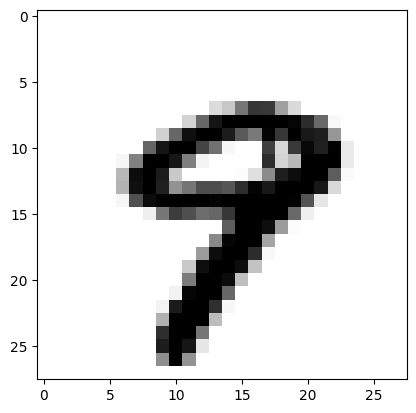

In [6]:
import matplotlib.pyplot as plt
import numpy as np

sample = x_test[9:10]
image = sample[0]
plt.imshow(image, cmap='gray_r')
plt.plot()

Then we have the model make a prediction. The output of the model making a prediction will be the probabilities, that the sample is of a certain class. Here, we have classes 0 to 9, representing the corresponding digits. The output (encapsulated into another array in the output of the predict function) is an array of length 10, where arr[i] is the probability of the sample belonging to class i.

In [7]:
prediction = model.predict(sample)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


array([[1.5321417e-12, 1.9668277e-13, 4.0530330e-09, 3.3098651e-08,
        1.4859749e-04, 3.7960586e-09, 1.5546140e-12, 2.4480411e-04,
        5.9366334e-07, 9.9960595e-01]], dtype=float32)

Hopefully, the highest probability should represent the class of our sample:

In [9]:
predictedclass = prediction[0].argmax()
print(f"Sample shows a {predictedclass}.")

Sample shows a 9.


If all of that worked, we have a functioning model and can go on to the next step: Converting.

## 2. Converting the model to ONNX

At the moment, our model does not exist outside of this runtime. Usually, before converting, we would have to save the model first. Our first conversion needed is however to convert our model into ONNX format, which can be easily done via the tf2onnx python package. Therefore, we first convert and then save our model.

We have to install some new packages first. Note, that tf2onnx might install a downgrade version of some other packages used by tensorflow, which may appear to be a dependency conflict first, but if you just "reinstall" the tensorflow package and let it install the newer versions of its dependencies, everything should work out fine.

In [ ]:
pip install tf2onnx
pip install tensorflow

In [10]:
import tf2onnx
import onnx

onnx_model, _ = tf2onnx.convert.from_keras(model, opset=13)
onnx.save(onnx_model, "model.onnx")

rewriter <function rewrite_constant_fold at 0x000002661EB4B380>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


## 3. Optimization

After converting the model to the ONNX format, now would be time to optimize the model to reduce its size and complexity. This could be done for example using the [ONNX Optimizer](https://github.com/onnx/optimizer?tab=readme-ov-file#onnx-optimizer). However, it has not yet been evaluated (within this work), how to best optimize a model for Tiny ML. Therefore, this step will be skipped for now.

## 4. Converting the model to C code

To convert our (optimized) ONNX model to C code, we use [onnx2c](https://github.com/kraiskil/onnx2c). Therefore, we first have to install onnx2c and then use it, to generate a C file containing our model. Note that this has only be successful on a Linux PC so far.

### Get and build onnx2c - Linux

To get and build onnx2c on a Linux PC, first install the ProtocolBuffers libraries, a dependecy of onnx2c, as follows:


In [ ]:
sudo apt install libprotobuv-dev protobuf-compiler

Then, clone the onnx2c github repository and update the submodules:

In [ ]:
git clone https://github.com/kraiskil/onnx2c.git
cd onnx2c
git submodule update --init

Finally, build onnx2c using CMake like so:

In [ ]:
mkdir build
cd build
cmake -DCMAKE_BUILD_TYPE=Release ..
make onnx2c

### Get and build onnx2c - Windows
#### ProtocolBuffers
Again, we first have to install the ProtocolBuffers C++ libraries including the protoc compiler, as they are a dependency of onnx2c. We need CMake, Ninja and MSYS2 for the following steps.
In an MSYS2 terminal (msys64/mingw64.exe), clone the protobuf git repository to a directory of your preference:

In [ ]:
git clone https://github.com/protocolbuffers/protobuf.git

Then, we have to configure the build. Therefore, navigate into the protobuf source directory (probably `cd protobuf`) and enter:

In [ ]:
cmake -S . -B build -G Ninja -DCMAKE_CXX_STANDARD=17 -DCMAKE_INSTALL_PREFIX=../install -DCMAKE_BUILD_TYPE=Release

If the previous step was successful, we can now compile the code using:

In [ ]:
cmake --build build --parallel 10

The official instructions include performing tests at this point. There will be no tests recognized when using the following command, and it therefore could probably be omitted. Just to be safe, we won't skip this step: 

In [ ]:
ctest --test-dir build --verbose

Finally, we can install the libraries using the following command:

In [ ]:
cmake --install build

If all of these steps were successful, the libraries and the protoc binary should now be in a directory called "install", at the same directory level as the protobuf directory.

#### onnx2c
Clone the repository and initiate git submodules with the following commands:

In [ ]:
git clone https://github.com/kraiskil/onnx2c.git
cd onnx2c
git submodule update --init


To make onnx2c compatible with windows, we first make some small changes to the code. Note that there are efforts to make onnx2c compatible with windows, so the following might not be necessary anymore at the time you are following these instructions.
Open the repository in a code editor like Visual Studio Code and perform the following changes:
1. Search for the macro `ERROR`. The name of this macro conflicts with some windows internals. Therefore, we need to change it. Change all occurences (use the code editors functionality to do so), for example to `ONNX2C_ERROR`.
2. We need to ensure that strings etc. are encoded as unicode in order to prevent conversion issues. Therefore, we first create a new directory called "platform" under "onnx2c/src/". Inside this platform, we create a new header file called "windows_common.h" with the following content:
    ```C
    #pragma once
    #ifdef _WIN32
    #ifndef UNICODE
    #define UNICODE
    #endif
    #ifndef _UNICODE
    #define _UNICODE
    #endif
    #ifndef WIN32_LEAN_AND_MEAN
    #define WIN32_LEAN_AND_MEAN
    #endif
    #include <windows.h>
    #endif
    ```
3. We now have to include the previously created header in the source files where it's necessary (All files that use strings, windows APIs, windows types or macros, or third-party includes that do any of the previous). At the time this instructions are written, those files should be:
    - error.h
    - graph.cc
    - main.cc
    - node.cc
    - options.cc
    - tensor.cc
    - (util.cc)
    - util.h

Now, we should be able to configure the build of onnx2c. In your MSYS2 terminal, move to the root directory of the onnx2c repository and enter the following commands:

In [ ]:
mkdir build
cd build
cmake -DCMAKE_BUILD_TYPE=Release -DCMAKE_PREFIX_PATH="your/protobuf/install/path" -DHAVE_STD_REGEX=ON -DRUN_HAVE_STD_REGEX=1 -G "MSYS Makefiles" ..

Where you exchange `"your/protoc/install/path"` for the path of the `install` directory you previously installed your protobuf in.
Finally, you should be able to build using the following command:

In [ ]:
make onnx2c

### Convert model

Now we can use onnx2c to generate a C file containing the model. We can do so from the command line in the directory where the onnx2c executable is built to as follows on Linux:

In [ ]:
./onnx2c path/to/model.onnx > model.c

For the same command on windows, just use the `.exe` ending for the binary:

In [ ]:
./onnx2c.exe path/to/model.onnx > model.c

## 5. Use model in C code
The C file generated by onnx2c contains everything the model needs to run. Note, that the model cannot be changed or trained anymore. The model can, however be used to make a prediction. The generated C file contains a function called `void entry(...)` (at the end of the file). Including the generated C file in your code (via writing a header file or directly), you can call this function with a sample as input argument. The function will (in our case) return an array of probabilities for the corresponding classes, as explained before.

To have something to predict, we will use our TensorFlow MNIST dataset and save our previously used sample in a format, that it can be copied and directly used as a C array:

In [11]:
with open("sample.c", 'a') as file:
    file.write("const float sample[1][28][28] = {{")

    for i in range(27):
        string_with_seperator = ','.join(sample[0][i].astype(str))
        file.write("{")
        file.write(string_with_seperator)
        file.write("},\n")

    string_with_seperator = ','.join(sample[0][i].astype(str))
    file.write("{")
    file.write(string_with_seperator)
    file.write("}")

    file.write("}};")


Now we can copy the generated array from the "sample.c" file and use it hardcoded for the moment in our C file. This is only for proof of concept and of course not recommended for real projects.
The following C file predicts the class of the sample:

```C
#include <stdio.h>
#include "model.c"

// Copy sample here like so:
// const float sample[1][28][28] = ... 

int main(void) {
    float tensor_output[1][10] = {{}};
    entry(sample, tensor_output);
    for (int i = 0; i < 10; i++)
    {
        printf("%d: %f\n", i, tensor_output[0][i]);
    }
    
    return 0;
}
```

You can find an example in the `example` directory of this repository.